# Curso de Machine Learning
# Reducción de dimensionalidad: PCA
## Luis Duarte, Sebastian Filipigh, Magdalena Lucini
### Septiembre 2023, FaCENA - UNNE
### Contacto:  luis.duarte@comunidad.unne.edu.ar; sfilipigh@comunidad.unne.edu.ar; mmlucini@comunidad.unne.edu.ar

**Objetivos:**

*   Aplicar Análisis de Componentes Principales (PCA) a situaciones con datos reales.
*   Realizar análisis gráfico de resultados.
*   Producir estimaciones a partir de las PCAs.


**Antes de empezar:**

Necesitamos importar las siguientes librerías:

In [ ]:
!pip install basemap
import numpy as np
%matplotlib inline
%pylab inline
from matplotlib import pyplot as plt
import pandas as pd
import io
import torch
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 12.3 MB/s eta 0:00:00


Populating the interactive namespace from numpy and matplotlib


## Primera parte: Construcción de las Componentes Principales


1.1) Importe la base de datos.

In [ ]:
uploaded = files.upload()

In [ ]:
bancos = pd.read_csv(io.BytesIO(uploaded['bancos.csv']))

*   Observe qué variables tiene la base de datos.
*   Obtenga las medidas de resumen para las variables.


In [ ]:
bancos

In [ ]:
bancos.describe()

La base de datos "bancos.csv" corresponde a 50 empresas argentinas que cotizan en bolsa, en ella se encuentran los siguientes indicadores calculados:

LIQACID : Liquidez ácida ((Act.Cte. - Bienes de Cambio)/Pasivo Cte)\
SOLVENC : Solvencia (Activo Total/Pasivo Total)\
PROPACT : Propiedad del Activo (Patrimonio Neto/Activo)\
PNOCOR :Pasivo No Cte./Activo,\
AUTOFIN :Autofinanciación (Utilidades no distribuidas/Activo),\
INMACT :Inmovilización del Activo (Activo no corriente/Activo),\
INMPN :Inmovilización del Patrim. Neto (Activo no corriente/P.Neto),\
RENTECO :Rentabilidad Económica (Utilidad antes de impuestos/Activo Total).

La matriz de datos $X$ es de clase $50\times 8$: el dataset completo con 50 bancos en $\mathbb{R}^{8}$ (8 variables)

$$X =\begin{bmatrix}
x_{1,1} & \cdots &  x_{1,8}\\
\vdots & \ddots & \vdots \\
x_{50,1} & \cdots &  x_{50,8}
\end{bmatrix} = \begin{bmatrix}
x_{1}\\
\vdots  \\
x_{50}
\end{bmatrix} $$

donde cada $x_i =(x_{i,1}, \cdots ,  x_{i,8} )$


Notar que NO se considera ninguna variable respuesta.

Conforme a la teoría del PCA, es esencial que los datos estén centrados.

* Calculemos el vector media 8-dimensional (en $\mathbb{R}^{8}$, un vector fila que contiene los promedios de cada variable).

 \begin{align*}
\bar{x}=& \frac{1}{50} \sum_{i=1}^{50} x_i \\
= & \frac{1}{50} \sum_{i=1}^{50}(x_{i,1}, \cdots ,  x_{i,8} )\\
=& (\bar{x}_1, \ldots ,\bar{x}_{8} )
\end{align*}



* Se consideran los datos centrados $X_c$: cada observación (fila) se le resta el vector de medias (es lo mismo que a cada columna se le reste la media de la columna).

\begin{align*}
X_c = & \begin{bmatrix}
(x_{1,1}-\bar{x}_1) & \ldots &  (x_{1,8}-\bar{x}_{8})\\
\vdots & \ddots & \vdots \\
(x_{50,1}-\bar{x}_1) & \ldots &  (x_{50,8}- \bar{x}_{8})
\end{bmatrix}\\
= & \begin{bmatrix}
(x_{1}-\overline{x})\\
\vdots  \\
(x_{n}-\overline{x})
\end{bmatrix}
\end{align*}

donde cada $x_i =(x_{i,1}, \ldots ,  x_{i,50} )$



In [ ]:
bancos=bancos.drop(bancos.columns[0], axis=1)
X= torch.Tensor(bancos.values)


In [ ]:
 #Centrar los datos
X_mean = torch.mean(X, 0)
Xc= X - X_mean.expand_as(X)

In [ ]:
X_mean

* La matriz de var-covarianzas de todo el dataset.
$$S= \frac{1}{n-1}X_c^{t}. X_c$$


- Representa la dispersión de los datos alrededor del vector promedio.

In [ ]:
S=1/49*Xc.t()@Xc
S

In [ ]:
S.diag()

tensor([29218.3516, 79418.1406,   434.4480,   153.5893,   516.6913,   333.5220,
        10460.0947,   154.9357])

Como las variables no presentan escalas similares (esto se observa con la comparación de las varianzas), es necesario trabajar con los datos escalados. Por tanto, en lugar de trabajar con la matriz de varianzas y covarianzas, trabajaremos con la matriz de correlación.

$$R=D^{-1/2}SD^{-1/2}$$
donde $D=\text{diag}(S_{1,1}, S_{2,2}, \ldots, S_{8,8})$.

In [ ]:
D=torch.diag(S.diag())
R=torch.inverse(torch.sqrt(D))@S@torch.inverse(torch.sqrt(D))
R

Más facil:


In [ ]:
R=torch.corrcoef(X.t())
R


* Se calculan los ejes de dispersión ortogonales:
- Los vectores $v_1,v_2,...,v_{8}$ (en $R^{8}$, de norma 1) y sus valores propios $\lambda_1,\lambda_2,...,\lambda_{8}$.
- $\lambda_1,\lambda_2,...,\lambda_{8}$: Valores propios ordenados de forma decreciente.
*Se eligen los primeros $k$  (con $k<8$).
* Estos vectores definen un nuevo espacio de dimensión $k$.
- Se construye una matriz $W$ (tamaño $8\times k$) donde cada columna es un vector propio normalizado (de norma o longitud 1).

In [ ]:
 # Calcular autovalores y autovectores
autovalores, autovectores = torch.linalg.eig(R)
autovalores

In [ ]:
# Ordenar autovalores y autovectores por los autovalores en orden descendente
autovalores = torch.real(autovalores)
orden = torch.argsort(autovalores, descending=True)
autovalores_ordenados=autovalores[orden]
autovectores_ordenados = autovectores[:,orden]
autovalores_ordenados

In [ ]:
#Proporción de Variabilidad Explicada
Prop=autovalores_ordenados/torch.sum(autovalores)
Prop

In [ ]:
# Proporción acumulada de Variabilidad Explicada
torch.cumsum(Prop,dim=0)

In [ ]:
# Gráfico de Sedimentación
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(Prop) + 1), Prop, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Gráfico de Sedimentación PCA')
plt.grid(True)
plt.show()

## ¿Cuántas componentes seleccionamos?
### Algunos criterios:

*   **Gráfico de sedimentación:** elegir las componentes (ordenadas de mayor a menor) hasta donde la pendiente comienza a nivelarse.
*   Seleccionar las componentes hasta cubrir un porcentaje determinado de la varianza.
*   **Establecer una cota mínima**; por ejemplo la varianza media. En el caso de trabajar con las variables estandarizadas: $\lambda \geq 1$.

In [ ]:
 #Seleccionar las 3 principales componentes
comp_princ=torch.real(autovectores_ordenados[:,:3])
nombres_filas = bancos.columns.tolist()
nombres_columnas = ["CP1", "CP2", "CP3"]
PCAs=pd.DataFrame(comp_princ.numpy(), index=nombres_filas, columns=nombres_columnas)
PCAs


,CP1,CP2,CP3
LIQACID,0.406662,-0.337307,-0.274601
SOLVENC,0.448823,-0.317399,-0.206612
PROPACT,0.470754,-0.045061,-0.206548
PNOCOR,-0.283440,0.032825,-0.613131
AUTOFIN,0.234643,0.588569,0.039654
INMACT,-0.224580,0.101112,-0.658663
INMPN,-0.412905,-0.105044,-0.023039
RENTECO,0.235061,0.643975,-0.165449


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(PCAs, *['CP1'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(PCAs, *['CP2'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(PCAs, *['CP3'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(PCAs, *['CP1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(PCAs, *['CP2'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(PCAs, *['CP3'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(PCAs, *[[['CP1', 'CP2'], ['CP2', 'CP3']]], **{})
chart

Todo lo hecho hasta aquí puede realizarse utilizando la función PCA de sklearn.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(bancos)
pca = PCA()
pca.fit(scaled_data)


PCA()

In [ ]:
#Varianza Explicada por las componentes
pca.explained_variance_

array([3.61917153, 1.43865387, 1.31390887, 0.79212632, 0.57384493,
       0.30217264, 0.08279028, 0.04059686])

In [ ]:
# Proporción de Varianza Explicada
PVE=pca.explained_variance_ratio_
PVE

array([0.44334851, 0.1762351 , 0.16095384, 0.09703547, 0.070296  ,
       0.03701615, 0.01014181, 0.00497312])

In [ ]:
# Proporción Acumulada de Varianza Explicada
np.cumsum(PVE)

array([0.44334851, 0.61958361, 0.78053745, 0.87757292, 0.94786893,
       0.98488508, 0.99502688, 1.        ])

In [ ]:
#Nos quedamos con las primeras 3 componentes
pca = PCA(n_components=3)
pca.fit(scaled_data)
PCAs2=pca.components_

* Graficamos las cargas de las variables en la primera componente.

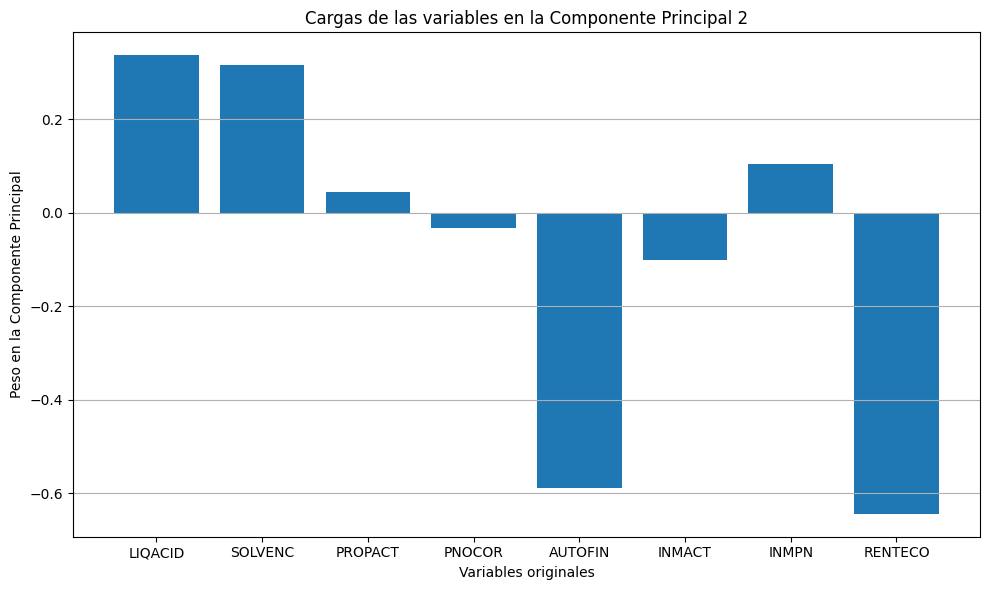

In [ ]:
component_number = 1  # 0 para la primera componente, 1 para la segunda, etc.
plt.figure(figsize=(10, 6))
plt.bar(range(PCAs2.shape[1]), PCAs2[component_number, :])
plt.xlabel('Variables originales')
plt.ylabel('Peso en la Componente Principal')
plt.title(f'Cargas de las variables en la Componente Principal {component_number + 1}')
plt.xticks(range(PCAs2.shape[1]), bancos.columns.tolist())
plt.grid(axis='y')
plt.tight_layout()
plt.show()

* Veamos los datos proyectados en el nuevo espacio generado por las tres primera componentes.

<ipython-input-27-8980664038d5>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(data_new[:, 0], data_new[:, 1], edgecolors='k', cmap=plt.cm.get_cmap('jet'))
<ipython-input-27-8980664038d5>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data_new[:, 0], data_new[:, 1], edgecolors='k', cmap=plt.cm.get_cmap('jet'))


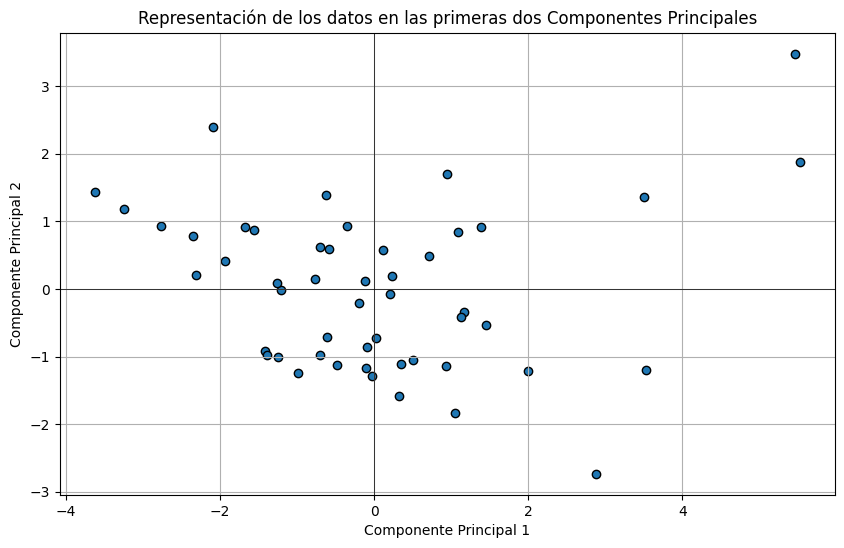

In [ ]:

data_new = pca.fit_transform(scaled_data) #Proyección de los datos en las nuevas componentes

# Visualizar datos en las primeras dos componentes
plt.figure(figsize=(10, 6))
plt.scatter(data_new[:, 0], data_new[:, 1], edgecolors='k', cmap=plt.cm.get_cmap('jet'))
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Representación de los datos en las primeras dos Componentes Principales')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
#plt.colorbar()
plt.show()

## Segunda parte: Aplicación de reducción de dimensiones a datos climáticos.

2.1) Importe el segundo conjunto de datos: SST.csv, el cual corresponde a las SST promedios (en Enero) en el golfo de México, para cada año entre 1998 y 2015. ¿Cuáles son las filas y columnas de este nuevo conjunto de datos?

In [ ]:
#from google.colab import files
uploaded = files.upload()

In [ ]:
SST = pd.read_csv(io.BytesIO(uploaded['SST.csv']))

In [ ]:
# Hechemos un vistazo a la tabla
SST

2.2) Usando las funciones *corrcoef* y *pcolor*, calcule y grafique la matriz de correlaciones entre los 1595 píxeles de SST.

In [ ]:
# calculamos la matriz de correlaciones
corr_sst = corrcoef(SST.T)
# plot the correlation matrix
pcolor(corr_sst, cmap='bwr', vmin=-1, vmax=1)
title('Correlación de la SST en el Golfo de México', size=20)
colorbar()


2.3) Luego, representamos gráficamente el mapa de correlación entre la SST en el píxel número 1300 y los otros 1594 píxeles. También mostramos la ubicación del píxel número 1300. Necesitaremos cargar la base de datos 'data1.csv' que contiene las coordenadas de los píxeles.

In [ ]:
# Importamos 'data1.csv'
uploaded = files.upload()

In [ ]:
data1=pd.read_csv(io.BytesIO(uploaded['data1.csv']))

In [ ]:
#Definimos una función que nos permita graficar:
# function to plot images
def plot_im(lon, lat, im, size_points, var_name, cmap, vmin, vmax):

    # transform to arrays (just in case)
    lon = array(lon)
    lat = array(lat)
    im = array(im)

    # Mercator projection (for small zone)
    m = Basemap(projection='merc', llcrnrlat=nanmin(lat), urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon), urcrnrlon=nanmax(lon), lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5, resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y = m(lon,lat)

    # plot
    im = ma.masked_where(isnan(im), im)
    res = m.scatter(x, y, size_points, im, 'o', alpha=1, cmap=cmap, lw=0, vmin=vmin, vmax=vmax)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(ceil(nanmin(lat)), floor(nanmax(lat)), 1+int(floor(nanmax(lat))-ceil(nanmin(lat))))
    meridians = linspace(ceil(nanmin(lon)), floor(nanmax(lon)), 1+int(floor(nanmax(lon))-ceil(nanmin(lon))))
    m.drawparallels(parallels, labels=[1,0,0,1], fontsize=10)
    m.drawmeridians(meridians, labels=[1,0,0,1], fontsize=10)
    cb = m.colorbar(res, location="right")
    cb.set_label(var_name, fontsize=20)

In [ ]:
# graficamos la correlación entre un píxel y los demás.
plt.figure(figsize=(15, 6))
plot_im(data1.lon, data1.lat, corr_sst[1300,:], 70, 'Correlation', cmap='bwr', vmin=-1, vmax=1)
title('Correlación entre la SST del píxel 1300 y las demás', size=20)

# print las coordenadas del píxel de interés
print('Longitud: ', str(360-data1.lon[1300]))
print('Latitud: ', str(data1.lat[1300]))

**Tarea:** Realice el mismo análisis para los píxeles 100 y 1000.

2.3) Calcule las primeras 10 PCA de la SST en el Golfo de México y trace el gráfico de sedimentación para la varianza explicada acumulada. ¿Cuántas componentes serían necesarias para explicar la variabilidad de la SST? (Hacer).

2.4) Trace las CPs que considere, almacenadas en SST_PCA.components_, utilizando la función *plot_im*. ¿Qué destacan las CPs? (Hacer)

2.5) Para finalizar, reconstruya el mapa de SST en enero de 1998 (es decir, la primera fila del conjunto de datos) utilizando las primeras $k$ CPs consideradas en los ítems anteriores. Para ello, proyecta el conjunto de datos original en el subespacio de dimensión $k$, utilizando la función de *transform* del objeto SST_PCA. Ten en cuenta que debes agregar la media de la SST al mapa reconstruido. (Hacer)

**Min Pts**

$Min Pts \leq p + 1, \text{ con } p = \text{ cantidad de variables.}$

$\text{Si el data set es muy ruidoso, } Min Pts \text{ debe ser al menos } 2p.
$

ϵ pequeño → muchos datos sin agrupar; ϵ muy grande → la
mayoría de los datos en un mismo grupo.
▶ puede elegirse usando un gráfico de distancias (gráfico de
codo, knee graph), representando la distancia al
k = minP ts − 1 vecino más cercano, ordenadas de mayor a
menor. Se elige ϵ donde se observa un codo.
▶ para cada punto se detecta su vecino más cercano, se fija ϵ
de manera tal que una proporción suficientemente gande de
observaciones (> 90%) tenga una distancia a su vecino más
cercano inferior a ϵ.



